# 使用序列模型预测正弦函数

In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from torch import nn

backend_inline.set_matplotlib_formats('svg')

# 数据准备
 首先，生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为t。

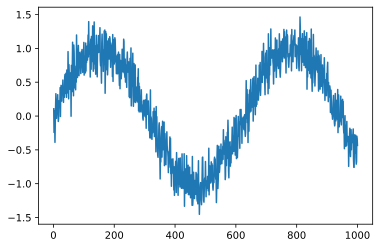

In [13]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
tau = 4
plt.plot(time, x)

   将这个序列转换为模型的“特征－标签”（feature-label）对，基于嵌入维度tau，将数据映射为数据对。将时刻t的前tau时刻的数据作为输入，用于预测时刻t的数值
例如：

    x = torch.tensor([1,2,3,4,5,6,7,8,9,10])
    tau = 4
有：

    features = tensor([
        [1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [3., 4., 5., 6.],
        [4., 5., 6., 7.],
        [5., 6., 7., 8.],
        [6., 7., 8., 9.]])
    labels = tensor([[ 5],[ 6],[ 7],[ 8],[ 9],[10]])


In [14]:
# 将features转化为为t时刻前的tau个数据
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
# 仅使用前600个数据进行训练
batch_size, n_train = 16, 600

创建数据迭代器，在批次内对数据进行打散（shuffle）

In [15]:
from torch.utils import data 
dataset = data.TensorDataset(features[:n_train], labels[:n_train])
train_iter = data.DataLoader(dataset, batch_size, shuffle=True)

# 训练模型

In [16]:
def init_weights(m:nn.Sequential):
    """初始化网络权重"""
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    """一个简单的多层感知机"""
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

def evaluate_loss(_net:nn.Sequential, _train_iter:data.DataLoader, _loss, device="cpu"):
    """实现损失函数计算"""
    result  = torch.tensor(0.).to(device)
    counter = torch.tensor(0.).to(device)
    _net = _net.to(device)
    with torch.no_grad():
        for k, (x, y) in enumerate(_train_iter):
            x = x.to(device)
            y = y.to(device)
            counter += x.shape[0]
            result += _loss(_net(x), y).sum()
        result = result / counter
    return result

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

def train(net:nn.Sequential, train_iter:data.DataLoader, loss, epochs:int, lr:float, device="cuda:0"):
    """训练多层感知机"""
    net = net.to(device)
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for x, y in train_iter:
            trainer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            l = loss(net(x), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss, device):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.065233
epoch 2, loss: 0.054521
epoch 3, loss: 0.055232
epoch 4, loss: 0.054050
epoch 5, loss: 0.050103


# 验证模型的预测效果
单步预测，即利用真实的分布数据来预测

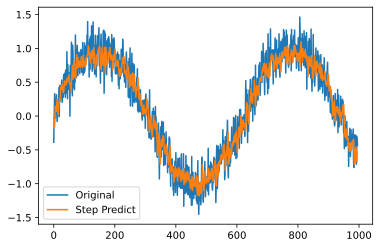

In [17]:
with torch.no_grad():
    result = net(features.cuda())
plt.plot(labels,)
plt.plot(result.cpu(),)
plt.legend(["Original", "Step Predict"])#标签映射

假设观测只到600，后续的序列需要神经网络自行推导，则有如下结果
- 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。

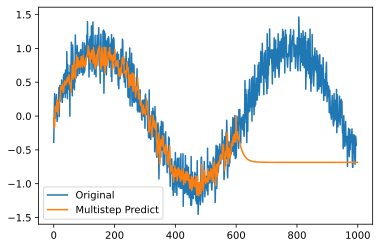

In [18]:
multistep_predicts = torch.zeros((T, 1), dtype=torch.float32).cuda()
net.cuda()
with torch.no_grad():
    result = net(features[:600].cuda())
    multistep_predicts[:600] = result
    for i in range(600 ,T-1):
        _x = multistep_predicts[i-4:i].squeeze()
        multistep_predicts[i+1] = net(_x)
plt.plot(labels,)
plt.plot(multistep_predicts.cpu(),)
plt.legend(["Original", "Multistep Predict"])#标签映射

展示k步预测的结果,即基于t时刻的观测, 输出t+k时刻的状态。在下面的例子中：
- k_predict中每一列都是数据。 从tau+1列开始，(tau+k) 列为 k 步预测。

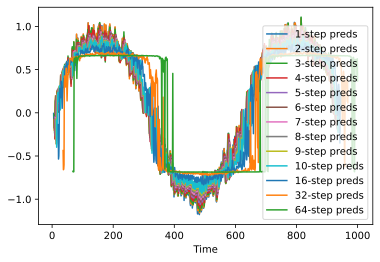

In [49]:
max_steps = 64
# k_predict.shape [933, 68]
k_predict = torch.zeros((T - tau - max_steps + 1, tau + max_steps), dtype=torch.float32).cuda()
# 列i (0 ~ tau) 是来自原始数据的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    k_predict[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i (tau~max_steps-tau) 是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    with torch.no_grad():
        k_predict[:, i] = net(k_predict[:, i - tau:i]).squeeze()

plt.xlabel("Time")
for i in (1,2,3,4,5,6,7,8,9,10,16,32,64):
    plt.plot(time[tau + i - 1: T - max_steps + i], k_predict[:, (tau + i - 1)].cpu(), label=f'{i}-step preds')
plt.legend()

以上例子清楚地说明了当试图预测更远的未来时，预测的质量是如何变化的。